## Setup

https://arxiv.org/pdf/2003.05991

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
from tqdm import tqdm
from openTSNE import TSNE
import os

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

# Move the entire dataset to GPU
train_images = train_set.data.unsqueeze(1).float().to(device)  # Add channel dimension and convert to float
train_images = (train_images / 255 - 0.1307) / 0.3081  # Apply normalization manually
train_labels = train_set.targets.to(device)

test_images = test_set.data.unsqueeze(1).float().to(device)
test_images = (test_images / 255 - 0.1307) / 0.3081
test_labels = test_set.targets.to(device)

# Create a new TensorDataset with the data now on the GPU
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(f'Image Shape: {images[0].shape}')

Image Shape: torch.Size([1, 28, 28])


## Linear Autoencoder

Encoder $z = W_e \cdot x + b_e$

Decoder $\hat{x} = W_d \cdot z + b_d $

$$\text{x (Input) -> We (Encoder) -> Z (Latent Space) -> Wd (Decoder) -> x' (Output)}$$

$$\hat{x} = W_e W_d x$$

In [110]:
class Linear_Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Linear_Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return z

class Linear_Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Linear_Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, output_dim)
        )

    def forward(self, z):
        x_hat = self.decoder(z)
        return x_hat

class Linear_Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim):
        super(Linear_Autoencoder, self).__init__()
        self.encoder = Linear_Encoder(input_dim, latent_dim)
        self.decoder = Linear_Decoder(latent_dim, output_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
input_dim = output_dim = 28 * 28
latent_dim = 64
    
linear_AE = Linear_Autoencoder(input_dim, latent_dim, output_dim).to(device)
print(linear_AE)

Linear_Autoencoder(
  (encoder): Linear_Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=64, bias=True)
    )
  )
  (decoder): Linear_Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=784, bias=True)
    )
  )
)


In [111]:
def visualize_features(model, dataloader, filename="latent_features.png", show_img=False):
  latent_vectors = []

  model.eval()
  with torch.no_grad():
      for X, y in dataloader:
          flattened_img = X.to(device).view(X.size(0), -1)
          latent_vector = model(flattened_img)
          latent_vectors.append(latent_vector.cpu().numpy())

  latent_vectors = np.concatenate(latent_vectors, axis=0)
  tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=False,
  )
  Z_reduced = tsne.fit(latent_vectors)

  plt.figure(figsize=(10, 7))
  plt.scatter(Z_reduced[:, 0], Z_reduced[:, 1], alpha=0.5, s=5)
  plt.title('Projection of Latent Vectors onto 2D Space')
  plt.xlabel('t-SNE Component 1')
  plt.ylabel('t-SNE Component 2')
  os.makedirs('results', exist_ok=True)
  save_path = os.path.join('results', filename)
  plt.savefig(save_path)
  if show_img:
        plt.show()
  plt.close()

In [112]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)

  for batch, (X, y) in enumerate(dataloader):
    flattened_img = X.to(device).view(X.size(0), -1)
    pred = model(flattened_img)

    reconstructed_pred = pred.view(pred.size(0), 1, 28, 28)
    loss = loss_fn(reconstructed_pred, X.to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
        loss_value, current = loss.item(), batch * len(X)
        # print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")
  return loss_value

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss = 0.0

  model.eval()

  with torch.no_grad():
    for X, y in dataloader:
      flattened_img = X.to(device).view(X.size(0), -1)
      pred = model(flattened_img)

      reconstructed_pred = pred.view(pred.size(0), 1, 28, 28)
      loss = loss_fn(reconstructed_pred, X.to(device))
      test_loss += loss.item()

  avg_loss = test_loss / num_batches
  # print(f"Test loss: {avg_loss:>7f}")
  return avg_loss

Epoch 1/50 - Train Loss 0.5525088906288147 Test Loss 0.5784084141254425
Epoch 2/50 - Train Loss 0.532000720500946 Test Loss 0.4634705185890198
Epoch 3/50 - Train Loss 0.4438435137271881 Test Loss 0.3920199483633041
Epoch 4/50 - Train Loss 0.34255871176719666 Test Loss 0.3506036251783371
Epoch 5/50 - Train Loss 0.34902259707450867 Test Loss 0.3216386795043945
Epoch 6/50 - Train Loss 0.3306874632835388 Test Loss 0.2988293021917343
Epoch 7/50 - Train Loss 0.29680976271629333 Test Loss 0.27997887134552
Epoch 8/50 - Train Loss 0.2795701026916504 Test Loss 0.2640862360596657
Epoch 9/50 - Train Loss 0.29320502281188965 Test Loss 0.2505410060286522
Epoch 10/50 - Train Loss 0.2299645096063614 Test Loss 0.23891484290361403
Epoch 11/50 - Train Loss 0.23122243583202362 Test Loss 0.22882851511240004
Epoch 12/50 - Train Loss 0.23172947764396667 Test Loss 0.22001027911901475
Epoch 13/50 - Train Loss 0.1737268716096878 Test Loss 0.21221346408128738
Epoch 14/50 - Train Loss 0.21813909709453583 Test Los

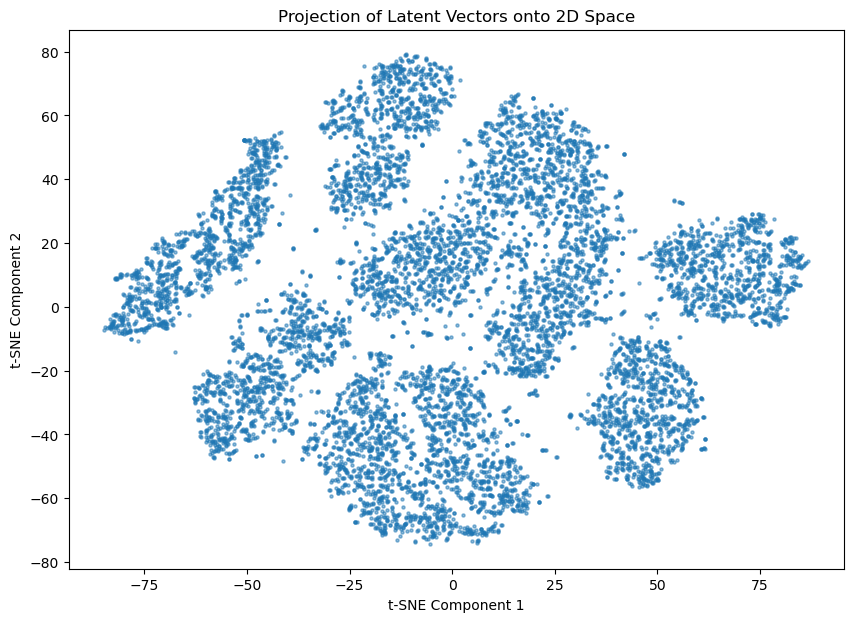

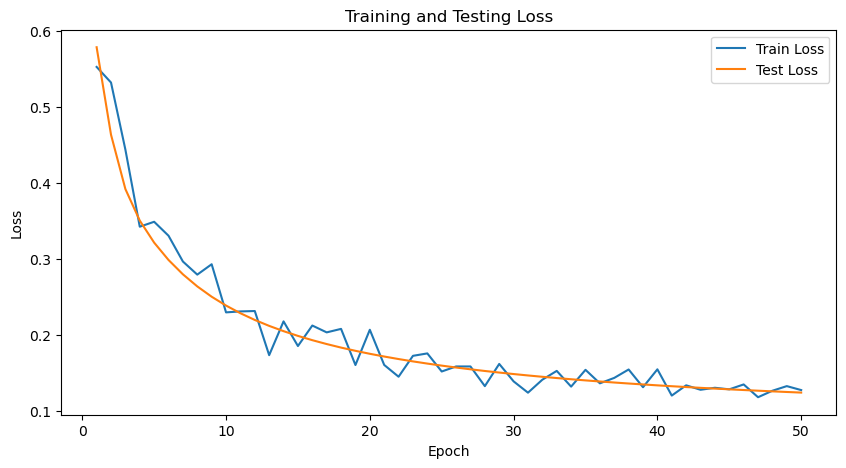

In [113]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(linear_AE.parameters(), lr=0.001, momentum=0.9)

train_losses = []
test_losses = []

num_epochs = 50
for epoch in range(num_epochs):

    train_loss = train_loop(train_loader, linear_AE, loss_fn, optimizer)
    test_loss = test_loop(test_loader, linear_AE, loss_fn)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss {train_loss} Test Loss {test_loss}")

visualize_features(linear_AE.encoder, test_loader, filename=f'latent_features_linearAE.png', show_img=True)
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

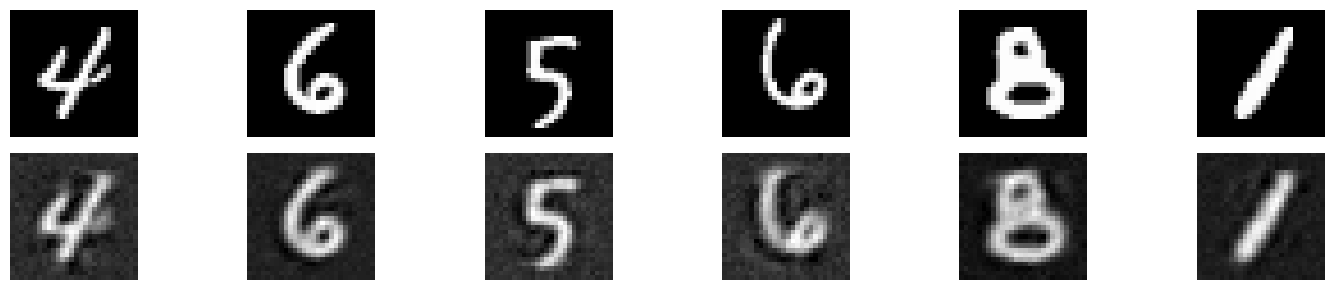

In [119]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(2, 6, figsize=(15, 3))

for i in range(6):
    image = images[i].cpu()
    label = labels[i].cpu()
    
    flattened_img = image.to(device).view(image.size(0), -1)
    pred = linear_AE(flattened_img).cpu()
    reconstructed_pred = pred.view(pred.size(0), 28, 28).detach().cpu()

    axes[0, i].imshow(image.squeeze(), cmap='gray')
    # axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_pred.squeeze(), cmap='gray')
    # axes[1, i].set_title(f"Reconstructed {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Non-Linear Autoencoder

In [31]:
def autoencoder_model(encoder_layers, latent_dim, decoder_layers):

  class Encoder(nn.Module):

    def __init__(self, input_dims, encoder_layers, latent_dim):
      super(Encoder, self).__init__()

      dims = []
      dims.append(input_dims)
      for i in range(1,encoder_layers+1):
        dims.append(int(input_dims//(i*2)))
      dims.append(latent_dim)

      layers = []
      for i in range(len(dims) - 1):
          layers.append(nn.Linear(dims[i], dims[i + 1]))
          if i < len(dims) - 2:
              layers.append(nn.ReLU())

      self.encoder_network = nn.Sequential(*layers)

    def forward(self, x):
      return self.encoder_network(x)

  class Decoder(nn.Module):

    def __init__(self, latent_dim, decoder_layers, output_dim):
      super(Decoder, self).__init__()

      dims = []
      dims.append(latent_dim)
      for j in range(decoder_layers, 0, -1):
        dims.append(int(output_dim/(j*2)))
      dims.append(output_dim)

      layers = []
      for i in range(len(dims) - 1):
          layers.append(nn.Linear(dims[i], dims[i + 1]))
          if i < len(dims) - 2:
              layers.append(nn.ReLU())
      # layers.append(nn.Sigmoid())

      self.decoder_network = nn.Sequential(*layers)

    def forward(self, x):
      return self.decoder_network(x)

  class model(nn.Module):

    def __init__(self, encoder_layers, latent_dim, decoder_layers):
      super(model, self).__init__()
      self.encoder = Encoder(input_dims=784, encoder_layers=encoder_layers, latent_dim=latent_dim)
      self.decoder = Decoder(latent_dim=latent_dim, decoder_layers=decoder_layers, output_dim=784)

    def forward(self, x):
      return self.decoder(self.encoder(x))

  return model(encoder_layers, latent_dim, decoder_layers)

encoder > decoder, decoder < encoder, encoder = decoder (deep)

In [32]:
AE = [[None, None] for _ in range(4)]

# Shallow Autoencoder
AE[0][0] = autoencoder_model(encoder_layers=0, latent_dim=64, decoder_layers=0).to(device)
AE[0][1] = torch.optim.SGD(AE[0][0].parameters(), lr=0.001, momentum=0.9)

# Dense Autoencoder
AE[1][0] = autoencoder_model(encoder_layers=2, latent_dim=64, decoder_layers=2).to(device)
AE[1][1] = torch.optim.SGD(AE[1][0].parameters(), lr=0.001, momentum=0.9)

# Encoder-heavy Autoencoder
AE[2][0] = autoencoder_model(encoder_layers=2, latent_dim=64, decoder_layers=1).to(device)
AE[2][1] = torch.optim.SGD(AE[2][0].parameters(), lr=0.001, momentum=0.9)

# Decoder-heavy Autoencoder
AE[3][0] = autoencoder_model(encoder_layers=1, latent_dim=64, decoder_layers=2).to(device)
AE[3][1] = torch.optim.SGD(AE[3][0].parameters(), lr=0.001, momentum=0.9)


AE[0] - Epoch 1/50 - Train Loss 0.6354967355728149 Test Loss 0.5865505576133728
AE[0] - Epoch 11/50 - Train Loss 0.23531271517276764 Test Loss 0.23349885046482086
AE[0] - Epoch 21/50 - Train Loss 0.1750086545944214 Test Loss 0.17415177971124648
AE[0] - Epoch 31/50 - Train Loss 0.145908921957016 Test Loss 0.14777501225471495
AE[0] - Epoch 41/50 - Train Loss 0.11633282899856567 Test Loss 0.1334869720041752
AE[1] - Epoch 1/50 - Train Loss 0.7330253720283508 Test Loss 0.6813112258911133
AE[1] - Epoch 11/50 - Train Loss 0.28514888882637024 Test Loss 0.30752872228622435
AE[1] - Epoch 21/50 - Train Loss 0.19853124022483826 Test Loss 0.21810659170150756
AE[1] - Epoch 31/50 - Train Loss 0.15889205038547516 Test Loss 0.17894552648067474
AE[1] - Epoch 41/50 - Train Loss 0.1901816874742508 Test Loss 0.1566645696759224
AE[2] - Epoch 1/50 - Train Loss 0.7132057547569275 Test Loss 0.6713113903999328
AE[2] - Epoch 11/50 - Train Loss 0.2274465560913086 Test Loss 0.23623633086681367
AE[2] - Epoch 21/50 

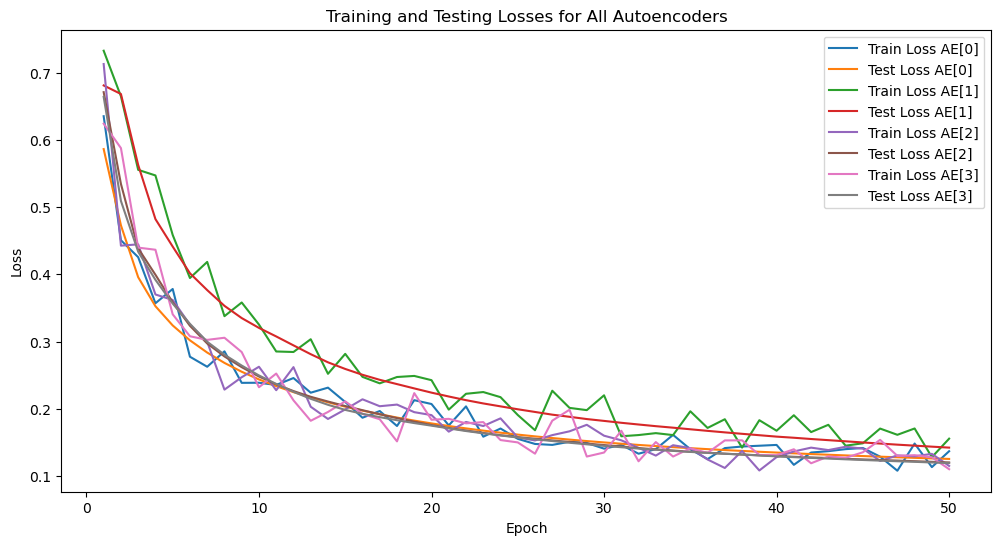

In [33]:
loss_fn = nn.MSELoss()

train_losses = [[] for _ in range(4)]
test_losses = losses = [[] for _ in range(4)]

for i in range(len(AE)):
  num_epochs = 50
  for epoch in range(num_epochs):
    train_loss = train_loop(train_loader, AE[i][0], loss_fn, AE[i][1])
    test_loss = test_loop(test_loader, AE[i][0], loss_fn)
    train_losses[i].append(train_loss)
    test_losses[i].append(test_loss)
    if epoch % 10 == 0: print(f"AE[{i}] - Epoch {epoch+1}/{num_epochs} - Train Loss {train_loss} Test Loss {test_loss}")

  visualize_features(AE[i][0].encoder, test_loader, filename=f'latent_features_AE[{i}].png', show_img=False)

plt.figure(figsize=(12, 6))

for i in range(len(AE)):
    plt.plot(range(1, num_epochs + 1), train_losses[i], label=f'Train Loss AE[{i}]')
    plt.plot(range(1, num_epochs + 1), test_losses[i], label=f'Test Loss AE[{i}]')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses for All Autoencoders')
plt.legend()
plt.show()

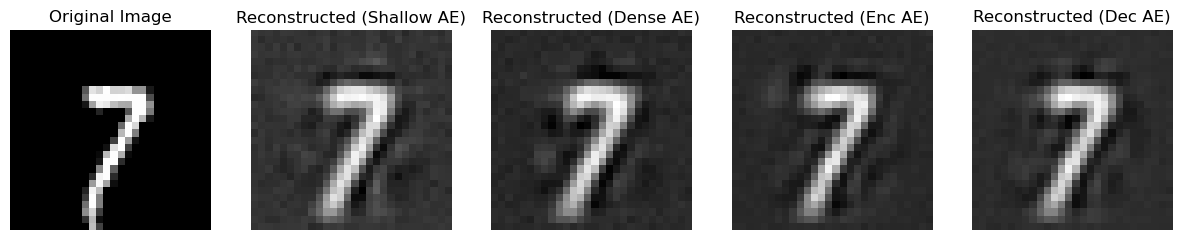

In [42]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

image = images[0]
label = labels[0]

flattened_img = image.to(device).view(1, -1)

reconstructed_images = []

for model in AE:
    pred = model[0](flattened_img).cpu()
    reconstructed_image = pred.view(28, 28).detach()
    reconstructed_images.append(reconstructed_image)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

axes[0].imshow(image.cpu().squeeze(), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

titles = ['Shallow AE', 'Dense AE', 'Enc AE', 'Dec AE']
for i, recon_img in enumerate(reconstructed_images):
    axes[i + 1].imshow(recon_img.squeeze(), cmap='gray')
    axes[i + 1].set_title(f"Reconstructed ({titles[i]})")
    axes[i + 1].axis('off')

plt.show()

## K-Sparse Autoencoder


https://arxiv.org/pdf/1312.5663

In [337]:
def ksparse_AEmodel(latent_dim, k):

  def top_k_sparsity(vector, k):
    topk_values, topk_indices = torch.topk(vector, k, largest=True, sorted=False)
    sparse_vector = torch.zeros_like(vector)
    sparse_vector.scatter_(1, topk_indices, topk_values)
    return sparse_vector

  class Encoder(nn.Module):

    def __init__(self, input_dims, latent_dim, k):
      super(Encoder, self).__init__()
      self.k = k
      self.fc1 = nn.Linear(input_dims, 128)
      self.fc2 = nn.Linear(128, latent_dim)

    def forward(self, x):
      x = self.fc1(x)
      x = top_k_sparsity(x, self.k)
      x = self.fc2(x)
      return x

  class Decoder(nn.Module):

    def __init__(self, latent_dim, output_dim, k):
      super(Decoder, self).__init__()
      self.k = k
      self.fc1 = nn.Linear(latent_dim, 128)
      self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
      x = self.fc1(x)
      x = top_k_sparsity(x, self.k)
      x = self.fc2(x)
      return x

  class model(nn.Module):

    def __init__(self, latent_dim, k):
      super(model, self).__init__()
      self.K = k
      self.encoder = Encoder(input_dims=784, latent_dim=latent_dim, k=k)
      self.decoder = Decoder(latent_dim=latent_dim, output_dim=784, k=k)

    def forward(self, x):
      self.latent = self.encoder(x)
      self.output = self.decoder(self.latent)
      return self.output

  return model(latent_dim, k)

In [339]:
# Sparse Autoencoder 
ksparse_AE = {i: [None, None] for i in range(10, 101, 20)}
for K in ksparse_AE:
    ksparse_AE[K][0] = ksparse_AEmodel(latent_dim=64, k=K).to(device)
    # ksparse_AE[K][1] = torch.optim.SGD(ksparse_AE[K][0].parameters(), lr=0.001, momentum=0.9)
    ksparse_AE[K][1] = torch.optim.Adam(ksparse_AE[K][0].parameters(), lr=0.001)

In [340]:
def ksparse_train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)

  for batch, (X, y) in enumerate(dataloader):
    flattened_img = X.to(device).view(X.size(0), -1)
    pred = model(flattened_img)
    reconstructed_pred = pred.view(pred.size(0), 1, 28, 28)
    loss = loss_fn(reconstructed_pred, X.to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
        loss_value, current = loss.item(), batch * len(X)
        # print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")
  return loss_value

K=10 - Epoch 1/25 - Train Loss 0.3656274676322937 Test Loss 0.3403026044368744
K=10 - Epoch 11/25 - Train Loss 0.24043220281600952 Test Loss 0.23869888633489608
K=10 - Epoch 21/25 - Train Loss 0.234236940741539 Test Loss 0.22717243134975434
K=30 - Epoch 1/25 - Train Loss 0.2691064774990082 Test Loss 0.252220718562603
K=30 - Epoch 11/25 - Train Loss 0.14850971102714539 Test Loss 0.1417081445455551
K=30 - Epoch 21/25 - Train Loss 0.13546572625637054 Test Loss 0.13326661437749862
K=50 - Epoch 1/25 - Train Loss 0.23058626055717468 Test Loss 0.21761386096477509
K=50 - Epoch 11/25 - Train Loss 0.10685355216264725 Test Loss 0.10475064814090729
K=50 - Epoch 21/25 - Train Loss 0.10175295919179916 Test Loss 0.09783435389399528
K=70 - Epoch 1/25 - Train Loss 0.22435908019542694 Test Loss 0.19878732711076735
K=70 - Epoch 11/25 - Train Loss 0.09192956984043121 Test Loss 0.09042110145092011
K=70 - Epoch 21/25 - Train Loss 0.08430272340774536 Test Loss 0.08179848194122315
K=90 - Epoch 1/25 - Train Lo

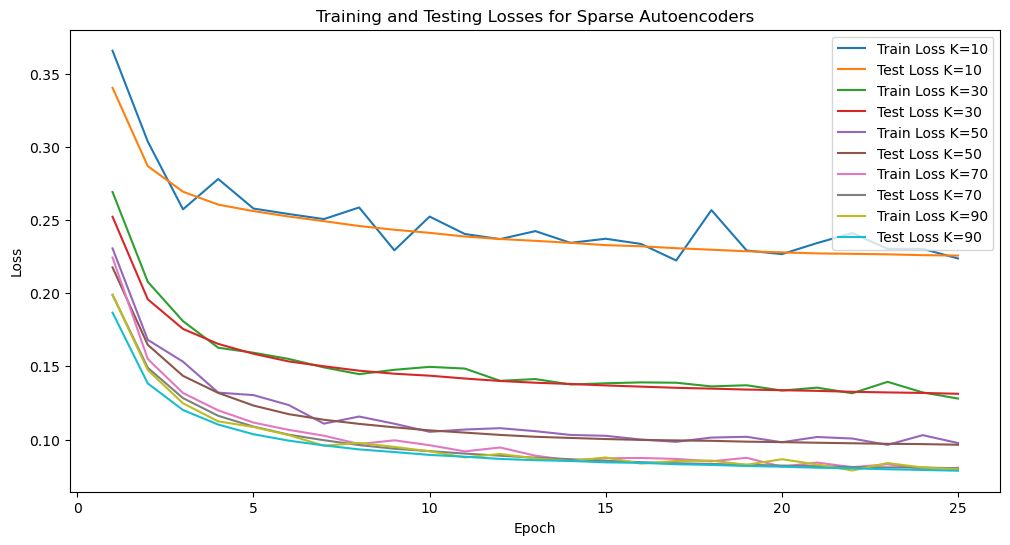

In [341]:
loss_fn = nn.MSELoss()

train_losses = {k: [] for k in ksparse_AE}
test_losses = {k: [] for k in ksparse_AE}

num_epochs = 25
for K in ksparse_AE:
    for epoch in range(num_epochs):
        train_loss = ksparse_train(train_loader, ksparse_AE[K][0], loss_fn, ksparse_AE[K][1])
        test_loss = test_loop(test_loader, ksparse_AE[K][0], loss_fn)
        train_losses[K].append(train_loss)
        test_losses[K].append(test_loss)
        if epoch % 10 == 0: print(f"K={K} - Epoch {epoch+1}/{num_epochs} - Train Loss {train_loss} Test Loss {test_loss}")

    visualize_features(ksparse_AE[K][0].encoder, test_loader, filename=f'KSparseAE_latent_features_K={K}.png', show_img=False)

plt.figure(figsize=(12, 6))

for K in ksparse_AE:
    plt.plot(range(1, num_epochs + 1), train_losses[K], label=f'Train Loss K={K}')
    plt.plot(range(1, num_epochs + 1), test_losses[K], label=f'Test Loss K={K}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses for Sparse Autoencoders')
plt.legend()
plt.show()

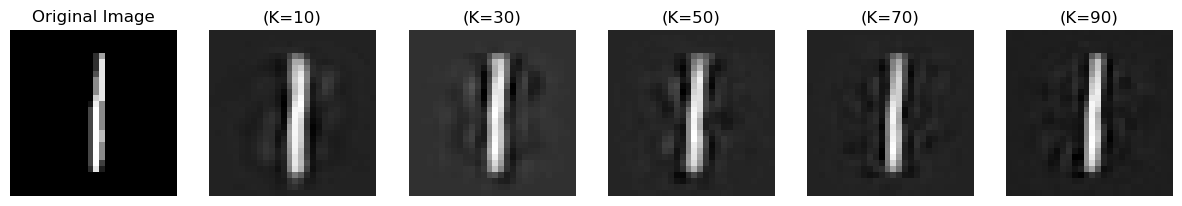

In [359]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

image = images[0]
label = labels[0]

flattened_img = image.to(device).view(1, -1)

reconstructed_images = {k: None for k in ksparse_AE}

for K in ksparse_AE:
    pred = ksparse_AE[K][0](flattened_img).cpu()
    reconstructed_image = pred.view(28, 28).detach()
    reconstructed_images[K] = reconstructed_image

fig, axes = plt.subplots(1, len(ksparse_AE)+1, figsize=(15, 3))

axes[0].imshow(image.cpu().squeeze(), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

for i, K in enumerate(reconstructed_images):
    axes[i+1].imshow(reconstructed_images[K].squeeze(), cmap='gray')
    axes[i+1].set_title(f"(K={K})")
    axes[i+1].axis('off')

plt.show()